# QOSF Mentorship Assessment (Task 2) - Simon Szalai

In [1]:
import math
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

#### Define hyperparameters

In [2]:
nr_qubits = 4
nr_layers = 32
learning_rate = 0.03
training_steps = 200

#### Define input and target states

In [3]:
# Define 4 random 4-qubit states in basis encoding
input_states = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Define target states in basis encoding that should be returned when above states are input to the network
target_states = np.array([
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 0]
])

#### Define helper functions for reusable assertions

In [4]:
def assert_basis_state(basis_state, nr_qubits):
    assert basis_state.shape[0] == nr_qubits, f"Length of input state ({basis_state.shape[0]}) must equal to number of qubits ({nr_qubits})."
    for bit in basis_state: assert bit == 0 or bit == 1, f"Input state {basis_state} is not valid. It can consist only of 0s and 1s."

In [5]:
def assert_params(params, nr_qubits, nr_layers):
    assert params.shape[0] == nr_layers, f"Parameters first dimension ({params.shape[1]}) must equal to the number of layers ({nr_layers})."
    assert params.shape[1] == nr_qubits, f"Parameters second dimension ({params.shape[0]}) must equal to the number of qubits ({nr_qubits})."
    assert params.shape[2] == 3, f"Parameters third dimension ({params.shape[2]}) must equal to 3."

#### Define helper functions for converting states in basis encoding to probability vectors

In [6]:
def get_vector_representation(basis_state):
    """
    A function that takes a basis state and returns it's single-qubit vector representation.

    Args:
        basis_state (int): Basis state to convert to vector. Either 0 or 1.

    Returns:
        np.array: Vector representation of a single-qubit basis state.
    """
    assert basis_state == 0 or basis_state == 1, f"Basis state has to be either 0 or 1. Instead got {basis_state}."

    if basis_state == 0:
        return np.array([1, 0])
    if basis_state == 1:
        return np.array([0, 1])


def basis_state_to_probability_vector(basis_state, nr_qubits):
    """
    A function that takes a quantum state in basis encoding and transforms it to a probability vector. Since it only accepts states in basis
    encoding (which includes only 0s and 1s), the probabilities equal the probability amplitudes, so no other conversion is needed to yield
    the probability vector.

    Args:
        input_state (np.array[int]): Input basis state in big endian encoding, consisting only of 0s and 1s. 
        nr_qubits (int): Number of qubits.

    Returns:
        np.array: Probability vector representing the chance of measuring each basis state. The binary form of the index of each element
        corresponds to the basis state, while the element itself corresponds to the probability of measuring that state.
        For example:
            In a 2 qubit system, getting an output of [0, 1, 0, 0] means that there is 100% chance of measuring |01> (binary form of decimal 1),
            and 0% chance of measuring anything else. Since PennyLane uses big endian encoding, |01> means measuring 0 on the first qubit
            and 1 on the second qubit.
    """

    assert_basis_state(basis_state, nr_qubits)

    # Assign state vector of first qubit to probability vector
    probability_vector = get_vector_representation(basis_state[0])

    # Loop through the rest of the qubits and combine states using Kronecker product (numpy implementation of tensor product)
    for i in range(1, len(basis_state)):
        probability_vector = np.kron(probability_vector, get_vector_representation(basis_state[i]))
        
    return probability_vector

#### Define parameterized ansatz that can be trained to prepare the target states

In [7]:
def layer(params, layer_index, nr_qubits, nr_layers):
    """
    One layer of the ansatz for the circuit that transforms 4 randomly choosen states to the target states. Parameterized X and Y rotations
    are added to each qubit, then the qubits are connected with CNOT gates in a chain pattern (each gate is controlled by the previous gate).

    Args:
        params (np.array): 3D array of trainable parameters. Dimensions should be (nr_qubits, nr_layers, 2)
        layer_index (int): Index of the current layer.
        nr_qubits (int): Number of qubits.
        nr_layers (int): Total number of layers.
    """
    assert_params(params, nr_qubits, nr_layers)

    for i in range(nr_qubits):
        qml.RX(params[layer_index, i, 0], wires=i)
        qml.RY(params[layer_index, i, 1], wires=i)
        qml.RZ(params[layer_index, i, 2], wires=i)


    qml.broadcast(qml.CNOT, wires=range(nr_qubits), pattern="chain")


# Set up PennyLane quantum simulator
dev = qml.device("default.qubit", wires=nr_qubits)


@qml.qnode(dev)
def ansatz(params, input_state, nr_qubits, nr_layers):
    """
    Circuit ansatz that transforms 4 randomly choosen states to the target states. It applies the number of specified layers, then returns
    the probability vector of the measurement.

    Args:
        params (np.array): 3D array of trainable parameters. Dimensions should be (nr_qubits, nr_layers, 2).
        input_state (np.array[int]): Input basis state in big endian encoding, consisting only of 0s and 1s. 
            Length must be equal to number of qubits.
        nr_qubits (int): Number of qubits.
        nr_layers (int): Total number of layers.

    Returns:
        qml.probs: Probability vector representing the chance of measuring each basis state.

    """
    assert_params(params, nr_qubits, nr_layers)
    assert_basis_state(input_state, nr_qubits)

    qml.templates.BasisStatePreparation(input_state, wires=range(nr_qubits))

    for layer_index in range(nr_layers):
        layer(params, layer_index, nr_qubits, nr_layers)

    probability_vector = qml.probs(wires=range(nr_qubits))

    return probability_vector

#### Create random initial parameters
np.array with shape `(nr_layers, nr_qubits, 3)`, each element between 0 and PI

In [8]:
params = np.random.normal(0, np.pi, (nr_layers, nr_qubits, 3))

#### Pre-compute the 4 target states as probability vectors to speed up training

In [9]:
target_prob_vectors = [basis_state_to_probability_vector(target_state, nr_qubits) for target_state in target_states]

#### Define cost function

In [10]:
def cost_fn(params, nr_qubits, nr_layers):
    """
    Process of calculating the loss: 
        1. Evaluate network with current params for each of the input states.
        2. Calculate the difference between the resulting probability vectors and the corresponding pre-computed target probability vectors.
        3. Calculate the absolute value of the resulting difference vector, so the losses with different signs don't cancel each other out.
        4. Sum the elements of the vector to yield a single scalar output.

    Args:
        params (np.array): 3D array of trainable parameters.
        nr_qubits (int): Number of qubits.
        nr_layers (int): Total number of layers.

    Returns:
        float: Cost as a scalar.

    """
    assert_params(params, nr_qubits, nr_layers)

    cost = 0
    for i, input_state in enumerate(input_states):
        result_prob_vector = ansatz(params, input_state, nr_qubits, nr_layers)
        cost += abs(result_prob_vector - target_prob_vectors[i]).sum()
    return cost

#### Train the network

In [11]:
# Define optimizer
opt = qml.GradientDescentOptimizer(stepsize=learning_rate)

# Create a list to store cost values along the training (so later can be visualized)
costs = []

# Start the training loop
for i in range(training_steps):
    # Update the circuit parameters and return the cost
    params, cost = opt.step_and_cost(cost_fn, params, nr_qubits=nr_qubits, nr_layers=nr_layers)

    # Register current iteration's cost value
    costs.append(cost)

    # Print training progress every 10 iteration
    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost))


Cost after step    10:  2.2853601
Cost after step    20:  0.4784647
Cost after step    30:  0.0804575
Cost after step    40:  0.0170597
Cost after step    50:  0.0044824
Cost after step    60:  0.0013172
Cost after step    70:  0.0004098
Cost after step    80:  0.0001316
Cost after step    90:  0.0000431
Cost after step   100:  0.0000143
Cost after step   110:  0.0000048
Cost after step   120:  0.0000016
Cost after step   130:  0.0000006
Cost after step   140:  0.0000002
Cost after step   150:  0.0000001
Cost after step   160:  0.0000000
Cost after step   170:  0.0000000
Cost after step   180:  0.0000000
Cost after step   190:  0.0000000
Cost after step   200:  0.0000000


#### Plot loss during training

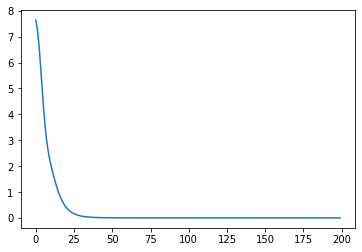

In [12]:
plt.plot(costs)

#### Some learinings during training
1. Increasing layer depth dramatically reduces the length of training required. For a simulator that's fine, but on a real device this might get problematic. Could be interesting to explore options to train faster with less layers. Maybe use a different optimizer (e.g. Quantum Natural Gradients), or use more qubits as auxiliary qubits.

    Loss after 100 iterations with learning rate of 0.05 and with different depths:

    Layers | Loss
      ---- | ----:
    4      | 2.2118232
    8      | 0.2961199
    16     | 0.0351823

2. As the networks gets deeper, lower learning rates are needed, otherwise training becomes unstable. For example, In the previous point, when trying a layer count of 32, after 20 iterations the loss jumped back to almost the initial value. After reducing learning rate to half, the training stabilized.


#### Define helper function to visualize probabilities

In [41]:
def plot_probs(input_state):
    probs = ansatz(params, input_state, nr_qubits, nr_layers).numpy()
    plt.xticks(rotation=90)
    plt.bar([f"{dec:b}".rjust(int(math.log(len(probs), 2)), "0") for dec in range(len(probs))], probs)

def plot_probs_for_4_states(states):
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle("Measurement probabilities", y=1.08, size=20)
    for i, input_state in enumerate(states):
        ax = fig.add_subplot(1,4,i+1)
        plot_probs(input_state)
        state_as_str = "".join([str(nr) for nr in states[i].numpy()])
        ax.set_title(f"For input state |{state_as_str}>")

#### Plot measurement probabilities for each of the 4 input states

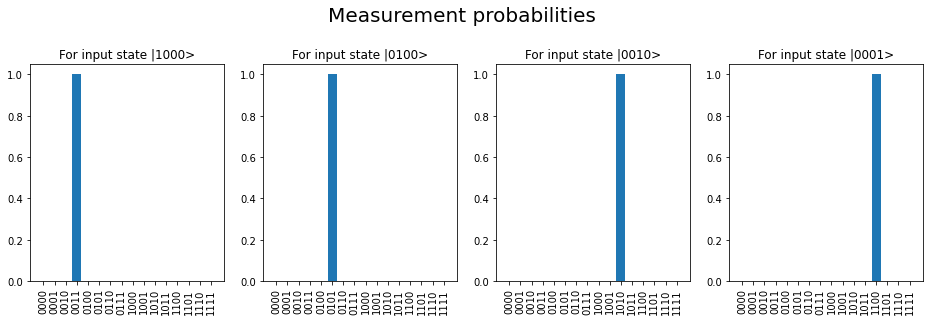

In [42]:
plot_probs_for_4_states(input_states)

#### Print values of the graph above

In [44]:
for i in range(4):
    print(f"Target state {i}: ", basis_state_to_probability_vector(target_states[i], nr_qubits).numpy())
    print(f"Output state {i}: ", ansatz(params, input_states[i], nr_qubits, nr_layers).numpy())
    print("==================================================================")

Target state 0:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Output state 0:  [2.58584859e-13 2.68691216e-12 7.31474852e-13 1.00000000e+00
 3.72227998e-12 1.42681185e-13 4.36898344e-12 1.84098389e-13
 4.42140542e-12 1.95969268e-12 6.24475417e-14 3.65848476e-12
 4.68022150e-13 1.05630794e-11 3.44029210e-12 1.04370250e-11]
Target state 1:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Output state 1:  [1.23923708e-12 6.66249546e-13 3.45354452e-12 1.42686685e-13
 1.10510841e-12 1.00000000e+00 8.47429558e-13 4.32652065e-12
 3.99632251e-12 4.60606881e-12 3.91128946e-13 2.29184544e-12
 1.21733565e-12 7.77710047e-13 8.88813359e-13 3.11490294e-12]
Target state 2:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Output state 2:  [1.25657458e-12 4.03027705e-12 4.36299908e-12 6.24519450e-14
 1.57957719e-13 3.91136225e-13 1.93698587e-12 9.65024836e-13
 1.94442860e-12 3.53328820e-12 1.00000000e+00 6.64575714e-13
 2.15709958e-13 8.48731133e-12 1.39066511e-13 9.28473950e-13]
Target state 3:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Output sta

#### What happens if we input different states to the network?

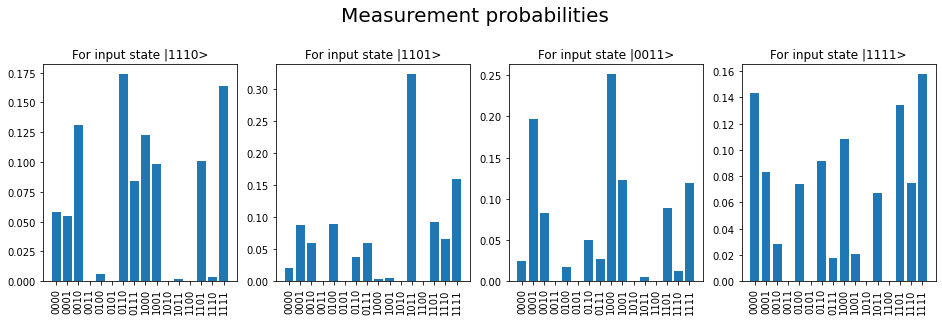

In [46]:
random_states = np.array([[1,1,1,0], [1,1,0,1], [0,0,1,1], [1,1,1,1]])
plot_probs_for_4_states(random_states)

If states that were not used for training are input to the network, the resulting measurement probabilities are divided between many states more or less evenly, instead of producing a given target state. This makes sense, since all the parameterized gates were trained to produce a certain target given a specific input, and those rotations result in completely different outcomes if novel states are introduced.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90d48d1c-1b3e-4c9b-9c50-fe452137d592' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>